<a href="https://colab.research.google.com/github/MarogobaCTD/UFPR/blob/main/AplicacaoRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importação das Bibliotecas
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [2]:
# carrega e arruma a base
!wget http://www.razer.net.br/datasets/spam.csv
df = pd.read_csv("spam.csv", encoding="ISO-8859-1")
df.head()
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
df.columns = ["labels", "data"]
df["b_labels"] = df["labels"].map({ "ham": 0, "spam": 1})
y = df["b_labels"].values

--2024-08-06 22:24:13--  http://www.razer.net.br/datasets/spam.csv
Resolving www.razer.net.br (www.razer.net.br)... 178.128.150.229
Connecting to www.razer.net.br (www.razer.net.br)|178.128.150.229|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 491.86K  --.-KB/s    in 0.1s    

2024-08-06 22:24:14 (4.26 MB/s) - ‘spam.csv’ saved [503663/503663]



In [3]:
# Separa a base em treino e teste
x_train, x_test, y_train, y_test = train_test_split(df["data"], y,
test_size=0.33)

In [4]:
# Número máximo de palavras para considerar
# São consideradas as mais frequentes, as demais são
# ignoradas
num_words = 20000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(x_train)
sequences_train = tokenizer.texts_to_sequences(x_train)
sequences_test = tokenizer.texts_to_sequences(x_test)
word2index = tokenizer.word_index
V = len(word2index)
print("%s tokens" % V)

7196 tokens


In [5]:
# Acerta o tamanho das sequências (padding)
data_train = pad_sequences(sequences_train) # usa o tamanho da maior seq.
T = data_train.shape[1] # tamanho da sequência
data_test = pad_sequences(sequences_test, maxlen=T)
print("data_train.shape: ", data_train.shape)
print("data_test.shape: ", data_test.shape)

data_train.shape:  (3733, 189)
data_test.shape:  (1839, 189)


In [6]:
# Define o modelo
D = 20 # tamanho do embedding, hiperparâmetro que pode ser escolhido
M = 5 # tamanho do hidden state, quantidade de unidades LSTM
i = Input(shape=(T,)) # Entra uma frase inteira
x = Embedding(V+1, D)(i)
x = LSTM(M)(x)
x = Dense(1, activation="sigmoid")(x) # Sigmoide pois só tem 2 valores
model = Model(i, x)

In [7]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 189)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 189, 20)             │         143,940 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 5)                   │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 144,466 (564.32 KB)

 Trainable params: 144,466 (564.32 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Compila e treina o modelo
model.compile(loss="binary_crossentropy", optimizer="adam",
metrics=["accuracy"])
epochs = 5
r = model.fit(data_train, y_train, epochs=epochs, validation_data=(data_test,
y_test))

Epoch 1/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 19s 90ms/step - accuracy: 0.8720 - loss: 0.5452 - val_accuracy: 0.8923 - val_loss: 0.3024
Epoch 2/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - accuracy: 0.9253 - loss: 0.2666 - val_accuracy: 0.9668 - val_loss: 0.1745
Epoch 3/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - accuracy: 0.9831 - loss: 0.1462 - val_accuracy: 0.9788 - val_loss: 0.1207
Epoch 4/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 0.9924 - loss: 0.0964 - val_accuracy: 0.9880 - val_loss: 0.0888
Epoch 5/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.9939 - loss: 0.0751 - val_accuracy: 0.9902 - val_loss: 0.0713


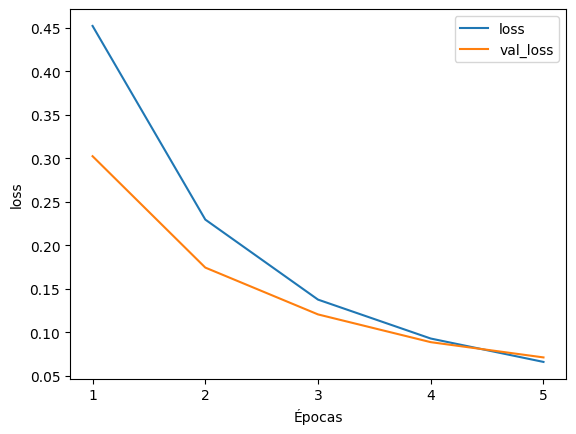

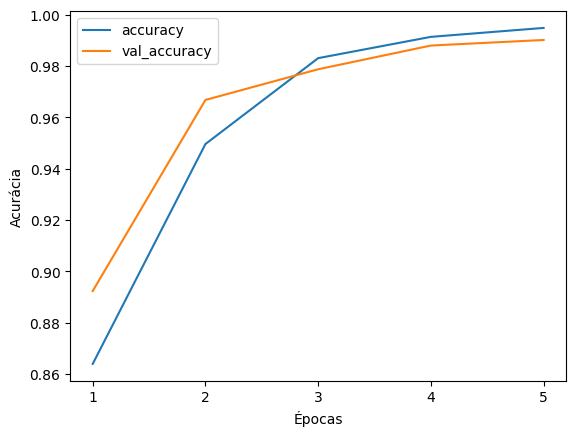

In [9]:
# Plota função de perda e acurácia
plt.plot(r.history["loss"], label="loss")
plt.plot(r.history["val_loss"], label="val_loss")
plt.xlabel("Épocas")
plt.ylabel("loss")
plt.xticks(np.arange(0, epochs, step=1), labels=range(1, epochs+1))
plt.legend()
plt.show()
plt.plot(r.history["accuracy"], label="accuracy")
plt.plot(r.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Épocas")
plt.ylabel("Acurácia")
plt.xticks(np.arange(0, epochs, step=1), labels=range(1, epochs+1))
plt.legend()
plt.show()

In [10]:
# Efetua a predição de um texto novo
#texto = "Hi, my name is Razer and want to tell you something."
texto = "Is your car dirty? Discover our new product. Free for all. Click the link."
seq_texto = tokenizer.texts_to_sequences([texto]) # Tokeniza
data_texto = pad_sequences(seq_texto, maxlen=T) # Padding
pred = model.predict(data_texto) # Predição
print(pred)
print ("SPAM" if pred >= 0.5 else "OK")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
[[0.5785592]]
SPAM
